<a href="https://colab.research.google.com/github/AsinaMilic/image_classification_with_vision_transformers/blob/main/levit_conv_512d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import cv2
import numpy as np
import torch
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from torchvision import models
!pip install scikit-learn
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
!pip install seaborn
!pip install timm
import timm
from timm.loss import LabelSmoothingCrossEntropy
import torch.nn as nn
import torch.optim as optim
import copy
from tqdm import tqdm
import time
from torch.cuda.amp import GradScaler, autocast
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 74.8 MB/s eta 0:00:00


# Constants

In [8]:
INPUT_SHAPE = (224, 224, 3) #512 is good too
BATCH_SIZE = 256
TRAIN_DIR = '/content/drive/MyDrive/Chiro10/train_512'
TEST_DIR = '/content/drive/MyDrive/Chiro10/test_512'
VAL_DIR = '/content/drive/MyDrive/Chiro10/val_512'
SAVE_PATH = '/content/drive/MyDrive/levit_conv_512d.pth'
NUM_EPOCHS = 100
DROP_OUT_RATE = 0.5
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
SCHEDULER_STEP_SIZE = 3
SCHEDULER_GAMMA = 0.97

#Loading the Data and training the model

In [9]:
class CustomDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label


def load_data(directory, input_shape):
    x = []
    y = []
    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            for file_name in os.listdir(class_dir):
                file_path = os.path.join(class_dir, file_name)
                image = cv2.imread(file_path)
                image = cv2.resize(image, (input_shape[1], input_shape[0]))
                x.append(image)
                y.append(class_name)
    x = np.array(x)
    y = np.array(y)
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    return x, y_encoded, label_encoder.classes_



def train_model(model, criterion, optimizer, scheduler, num_epochs=NUM_EPOCHS):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Initialize the history
    history = {
        'train': {'loss': [], 'acc': [], 'precision': [], 'recall': [], 'f1': []},
        'val': {'loss': [], 'acc': [], 'precision': [], 'recall': [], 'f1': []}
    }

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Containers to gather epoch-wise predictions and labels
            epoch_preds = []
            epoch_labels = []

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                epoch_preds.extend(preds.cpu().numpy())
                epoch_labels.extend(labels.cpu().numpy())

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            # Calculate metrics
            epoch_precision = precision_score(epoch_labels, epoch_preds, average='macro', zero_division=1)
            epoch_recall = recall_score(epoch_labels, epoch_preds, average='macro', zero_division=1)
            epoch_f1 = f1_score(epoch_labels, epoch_preds, average='macro', zero_division=1)

            # Print metrics
            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Precision: {epoch_precision:.4f} Recall: {epoch_recall:.4f} F1: {epoch_f1:.4f}")

            # Store metrics in history
            history[phase]['loss'].append(epoch_loss)
            history[phase]['acc'].append(epoch_acc.item())
            history[phase]['precision'].append(epoch_precision)
            history[phase]['recall'].append(epoch_recall)
            history[phase]['f1'].append(epoch_f1)

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)
    return model, history


def evaluate_model(model, criterion, dataloader):
    model.eval()  # Set model to evaluate mode

    running_loss = 0.0
    running_corrects = 0
    all_preds = []  # to collect all predictions
    all_labels = []  # to collect all true labels

    # Iterate over data.
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward
        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        # Append current batch of predictions and true labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)

    # Computing other metrics after the loop is done
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    print('{} Loss: {:.4f} Acc: {:.4f}'.format('test', epoch_loss, epoch_acc))
    print('Precision: {:.4f}'.format(precision))
    print('Recall: {:.4f}'.format(recall))
    print('F1-score: {:.4f}'.format(f1))



# Učitavanje podataka
x_train, y_train, classes = load_data(TRAIN_DIR, INPUT_SHAPE)
x_test, y_test, _ = load_data(TEST_DIR, INPUT_SHAPE)
x_val, y_val, _ = load_data(VAL_DIR, INPUT_SHAPE)

#print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
#print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")
#print(f"x_val shape: {x_val.shape} - y_val shape: {y_val.shape}")

# Augmentacija samo za trening set
train_transform = T.Compose([
    T.ToPILImage(),
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(15),
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

# Transformacija bez augmentacija za test i validaciju
eval_transform = T.Compose([
    T.ToPILImage(),
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

train_dataset = CustomDataset(x_train, y_train, transform=train_transform)
val_dataset = CustomDataset(x_val, y_val, transform=eval_transform)
test_dataset = CustomDataset(x_test, y_test, transform=eval_transform)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True)

dataloaders = {
    "train": train_dataloader,
    "val": val_dataloader
}

dataset_sizes = {
    "train": len(train_dataset),
    "val": len(val_dataset)
}

# Model, Optimizer & Loss
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = timm.create_model('levit_conv_512d', pretrained=False)
model.head = nn.Sequential(
    nn.Dropout(DROP_OUT_RATE),
    nn.Linear(model.head.linear.in_features, len(classes))
)
model, criterion = model.to(device), LabelSmoothingCrossEntropy().to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=SCHEDULER_STEP_SIZE, gamma=SCHEDULER_GAMMA)

# Obuka i evaluacija
model, history = train_model(model, criterion, optimizer, scheduler)
evaluate_model(model, criterion, test_dataloader)
torch.save(model.state_dict(), SAVE_PATH)

Epoch 0/99
----------
train Loss: 2.0898 Acc: 0.3304 Precision: 0.2848 Recall: 0.3131 F1: 0.2876
val Loss: 2.0755 Acc: 0.3225 Precision: 0.4633 Recall: 0.3031 F1: 0.2639

Epoch 1/99
----------
train Loss: 1.6243 Acc: 0.4800 Precision: 0.4605 Recall: 0.4614 F1: 0.4569
val Loss: 1.6551 Acc: 0.4851 Precision: 0.5629 Recall: 0.4895 F1: 0.4756

Epoch 2/99
----------
train Loss: 1.4020 Acc: 0.5970 Precision: 0.5853 Recall: 0.6018 F1: 0.5919
val Loss: 1.7461 Acc: 0.4173 Precision: 0.5217 Recall: 0.3953 F1: 0.3785

Epoch 3/99
----------
train Loss: 1.3150 Acc: 0.6533 Precision: 0.6441 Recall: 0.6381 F1: 0.6397
val Loss: 1.4572 Acc: 0.5393 Precision: 0.5396 Recall: 0.5100 F1: 0.4993

Epoch 4/99
----------
train Loss: 1.2463 Acc: 0.6782 Precision: 0.6661 Recall: 0.6673 F1: 0.6642
val Loss: 1.3666 Acc: 0.6206 Precision: 0.7082 Recall: 0.5872 F1: 0.5664

Epoch 5/99
----------
train Loss: 1.2040 Acc: 0.6739 Precision: 0.6649 Recall: 0.6533 F1: 0.6531
val Loss: 1.7565 Acc: 0.5257 Precision: 0.5974 R

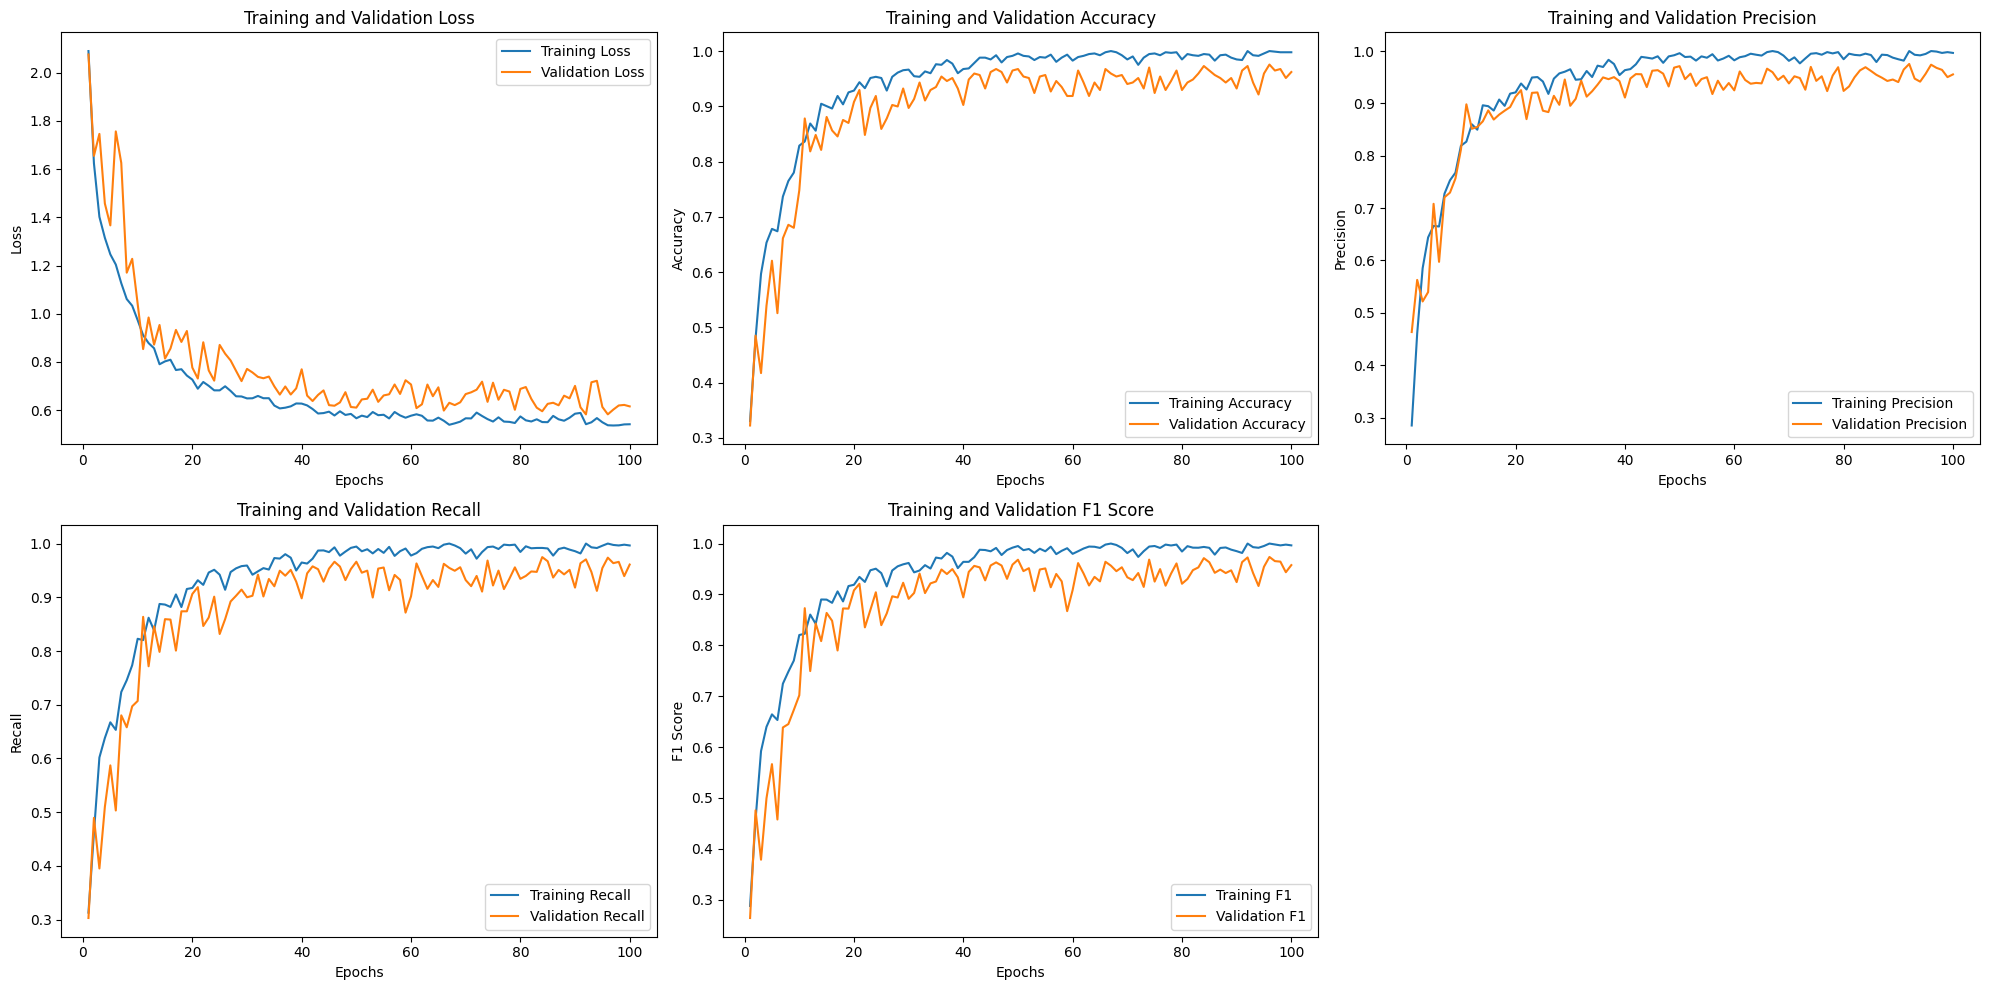

In [10]:
def plot_training_history(history):
    epochs = range(1, len(history['train']['loss']) + 1)

    plt.figure(figsize=(20, 10))

    # Plot training & validation loss
    plt.subplot(2, 3, 1)
    plt.plot(epochs, history['train']['loss'], label='Training Loss')
    plt.plot(epochs, history['val']['loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training & validation accuracy
    plt.subplot(2, 3, 2)
    plt.plot(epochs, history['train']['acc'], label='Training Accuracy')
    plt.plot(epochs, history['val']['acc'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training & validation precision
    plt.subplot(2, 3, 3)
    plt.plot(epochs, history['train']['precision'], label='Training Precision')
    plt.plot(epochs, history['val']['precision'], label='Validation Precision')
    plt.title('Training and Validation Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()

    # Plot training & validation recall
    plt.subplot(2, 3, 4)
    plt.plot(epochs, history['train']['recall'], label='Training Recall')
    plt.plot(epochs, history['val']['recall'], label='Validation Recall')
    plt.title('Training and Validation Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()

    # Plot training & validation F1-score
    plt.subplot(2, 3, 5)
    plt.plot(epochs, history['train']['f1'], label='Training F1')
    plt.plot(epochs, history['val']['f1'], label='Validation F1')
    plt.title('Training and Validation F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)


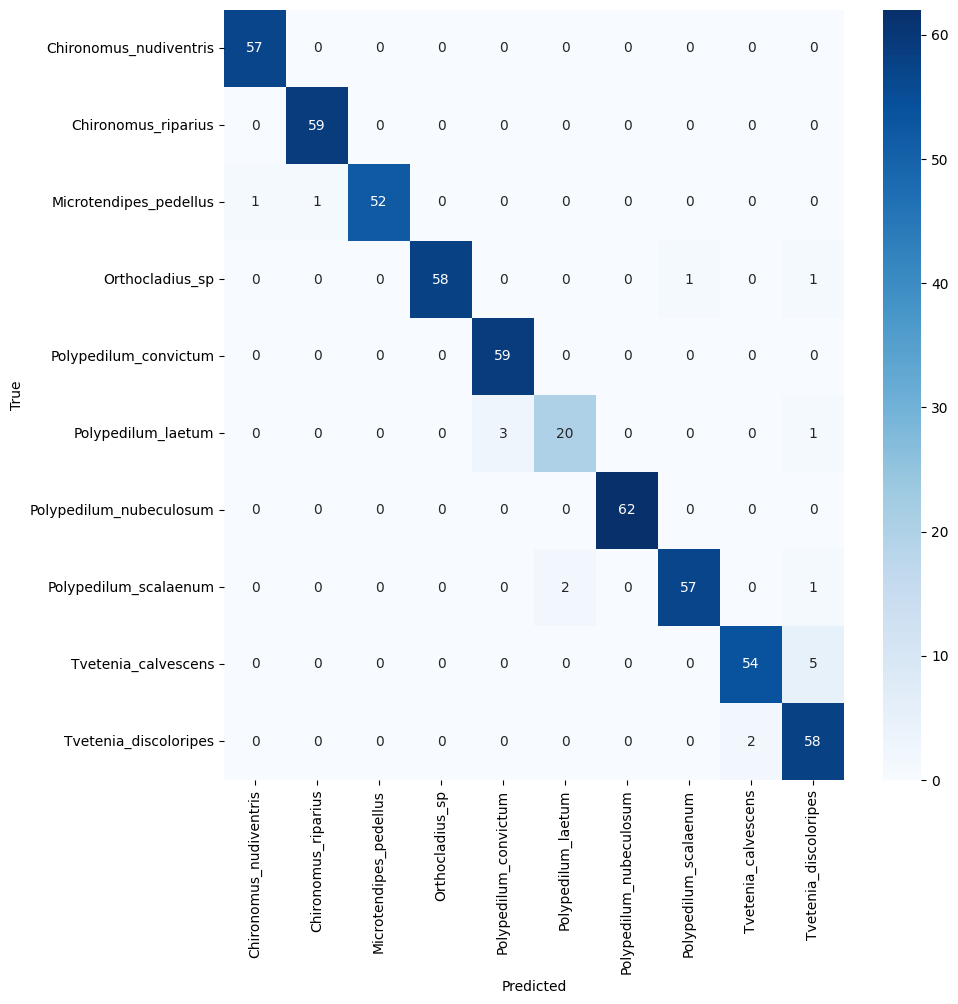

In [13]:
def plot_confusion_matrix(model, dataloader, classes):
    model.eval()
    true_labels = []
    pred_labels = []

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(10,10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_confusion_matrix(model, test_dataloader, classes)

In [12]:
print("\nEvaluation on Validation Data:")
evaluate_model(model, criterion, val_dataloader)
print("\nEvaluation on Test Data:")
evaluate_model(model, criterion, test_dataloader)



Evaluation on Validation Data:
test Loss: 0.5826 Acc: 0.9756
Precision: 0.9739
Recall: 0.9738
F1-score: 0.9736

Evaluation on Test Data:
test Loss: 0.5949 Acc: 0.9675
Precision: 0.9653
Recall: 0.9595
F1-score: 0.9618


Accuracy of this model on Test Dataset is 96.75%

Further improvements could be possible...